In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

from keras.preprocessing.image import load_img, img_to_array

import visualkeras

import os
import glob as gb

In [ ]:
pip install visualkeras

In [3]:
import warnings
warnings.filterwarnings("ignore")

Notebook Sections:
*   [Reading Images As Numpy Arrays](#1)
*   [Data Analysis & Visualistion](#2)
*   [Data Preprocessing](#3)
*   [CNN Construction & Modelling](#4)
*   [Transfer Learning Using VGG16](#5)
*   [Fine Tuning VGG16-Based Model](#6)
*   [Conclusion](#7)




# Downloading Kaggle Dataset 

This section is included for running the notebook in Google Colab, and should be ignored otherwise.

In [4]:
mkdir -p ~/.kaggle/

In [5]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:15<00:00, 205MB/s]
100% 2.29G/2.29G [00:15<00:00, 163MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

<a name="1"></a>
#Reading Images As Numpy Arrays

In this section we will read the images from their path as numpy arrays. The images are split into train, dev and test sets. 

In [9]:
code = {'NORMAL':0 ,'PNEUMONIA':1}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [10]:
classes = ['Normal', 'Pneumonia']

In [11]:
img_size = 150

In [12]:
def read_images_from_path(path, img_dim, grey_scale=0):
  X = []
  y = []
  for folder in  os.listdir(path) : 
    files = gb.glob(pathname= str(path + folder + '/*.jpeg'))
    for file in files:
        #read as grey scale image
        if grey_scale == 1:
          image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        else:
          image = cv2.imread(file)
        image_array = cv2.resize(image , (img_dim, img_dim))
        X.append(list(image_array))
        y.append(code[folder])
  return np.array(X), np.array(y)

In [13]:
#reading images in grey scale
X_train, y_train = read_images_from_path('/content/chest_xray/train/', img_size, 1)
X_val, y_val = read_images_from_path('/content/chest_xray/val/', img_size, 1)
X_test, y_test = read_images_from_path('/content/chest_xray/test/', img_size, 1)

In [14]:
print('X_train Shape: ' + str(X_train.shape))
print('X_test Shape: ' + str(X_test.shape))
print('X_val Shape: ' + str(X_val.shape))

X_train Shape: (5216, 150, 150)
X_test Shape: (624, 150, 150)
X_val Shape: (16, 150, 150)


<a name="2"></a>
# Data Analysis & Visualisation

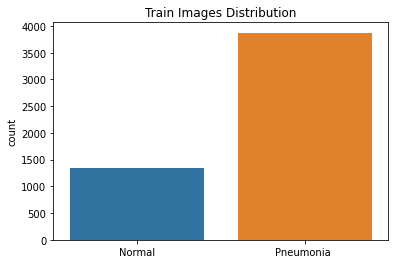

In [15]:
count = []
for i in y_train:
    if(i == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia ")
sns.countplot(count)
plt.title('Train Images Distribution')
plt.show()

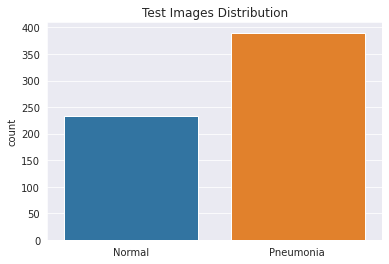

In [ ]:
count = []
for i in y_test:
    if(i == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia ")
sns.countplot(count)
plt.title('Test Images Distribution')
plt.show()

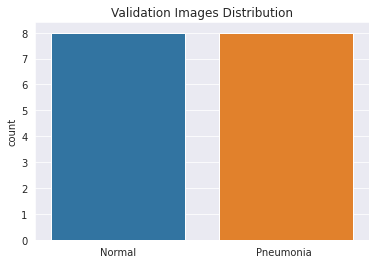

In [ ]:
count = []
for i in y_val:
    if(i == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia ")
sns.countplot(count)
plt.title('Validation Images Distribution')
plt.show()

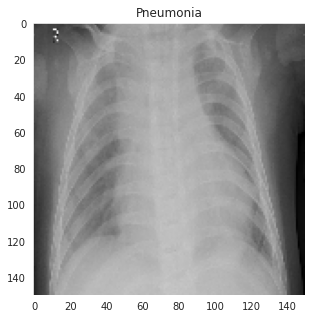

In [ ]:
#viewing a random image 
img_no = np.random.randint(0, X_train.shape[0])
plt.figure(figsize = (5,5))
plt.imshow(X_train[img_no], cmap='gray')
plt.title(classes[y_train[img_no]])
plt.grid(False)
plt.show()

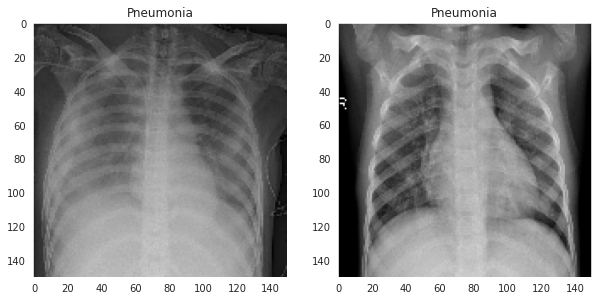

In [ ]:
img_no = np.random.randint(0, X_train.shape[0])
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(X_train[img_no])
axs[0].set_title(classes[y_train[img_no]])
axs[1].imshow(X_train[img_no + 1])
axs[1].set_title(classes[y_train[img_no + 1]])
axs[0].grid(False)
axs[1].grid(False)
plt.show()

<a name="3"></a>
# Data Preprocessing

In [16]:
#normalize images to get them in range of 0:1
X_train = X_train /255
X_val = X_val /255
X_test = X_test /255 

In [19]:
#reshaping images
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_val = X_val.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

In [20]:
print('X_train Shape: ' + str(X_train.shape))
print('X_test Shape: ' + str(X_test.shape))
print('X_val Shape: ' + str(X_val.shape))

X_train Shape: (5216, 150, 150, 1)
X_test Shape: (624, 150, 150, 1)
X_val Shape: (16, 150, 150, 1)


## Data Augmentation

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

In [22]:
datagen.fit(X_train)

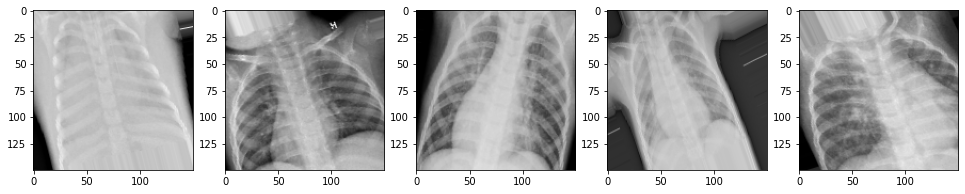

In [ ]:
#viewing images generated from Data Augmentation 
view_datagen = datagen.flow(X_train, batch_size=1)

plt.figure(figsize=(20,15))


for i in range(1, 6):
  plt.subplot(1, 6, i)
  batch = view_datagen.next()
  image = batch[0]
  plt.imshow(image)
plt.show()

## Class Weights To Correct Class Imbalance

As we saw in the analysis, the pnuemonia casses are much more represented in the train data rather than the normal cases. To help correct this we will initalize class weights for our models.

In [ ]:
TRAIN_IMG_COUNT = len(os.listdir('/content/chest_xray/chest_xray/train/NORMAL/')) + len(os.listdir('/content/chest_xray/chest_xray/train/PNEUMONIA/'))
COUNT_NORMAL = len(os.listdir('/content/chest_xray/chest_xray/train/NORMAL/'))
COUNT_PNEUMONIA = len(os.listdir('/content/chest_xray/chest_xray/train/PNEUMONIA/'))

weight_for_0 = TRAIN_IMG_COUNT / (2 * COUNT_NORMAL)
weight_for_1 = TRAIN_IMG_COUNT / (2 * COUNT_PNEUMONIA)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
print('Weight For Normal Class: ' + str(weight_for_0))
print('Weight For Pneumonia Class: ' + str(weight_for_1))

Weight For Normal Class: 1.9441132637853948
Weight For Pneumonia Class: 0.6731166150670794


<a name="4"></a>
# CNN Construction & Modelling

In this section we will construct a CNN from scratch. The CNN will then be fitted to our train data. 

## Model Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), padding='same',activation='relu', input_shape=(150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2))
model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2))
model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2))
model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

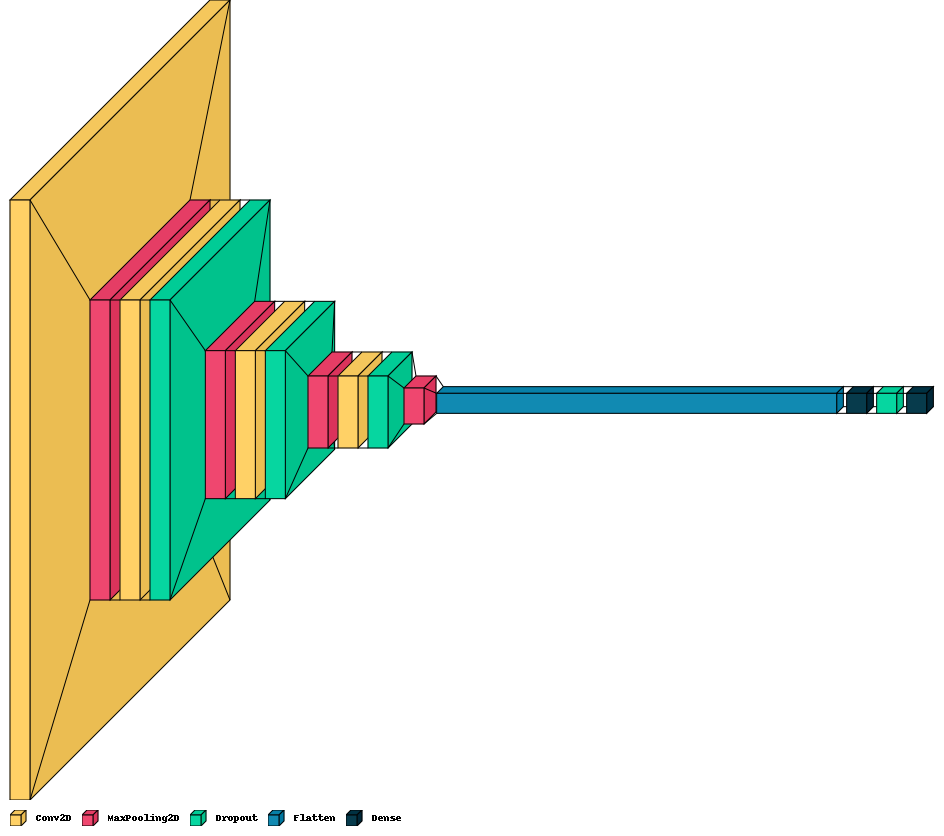

In [ ]:
visualkeras.layered_view(model, legend=True)

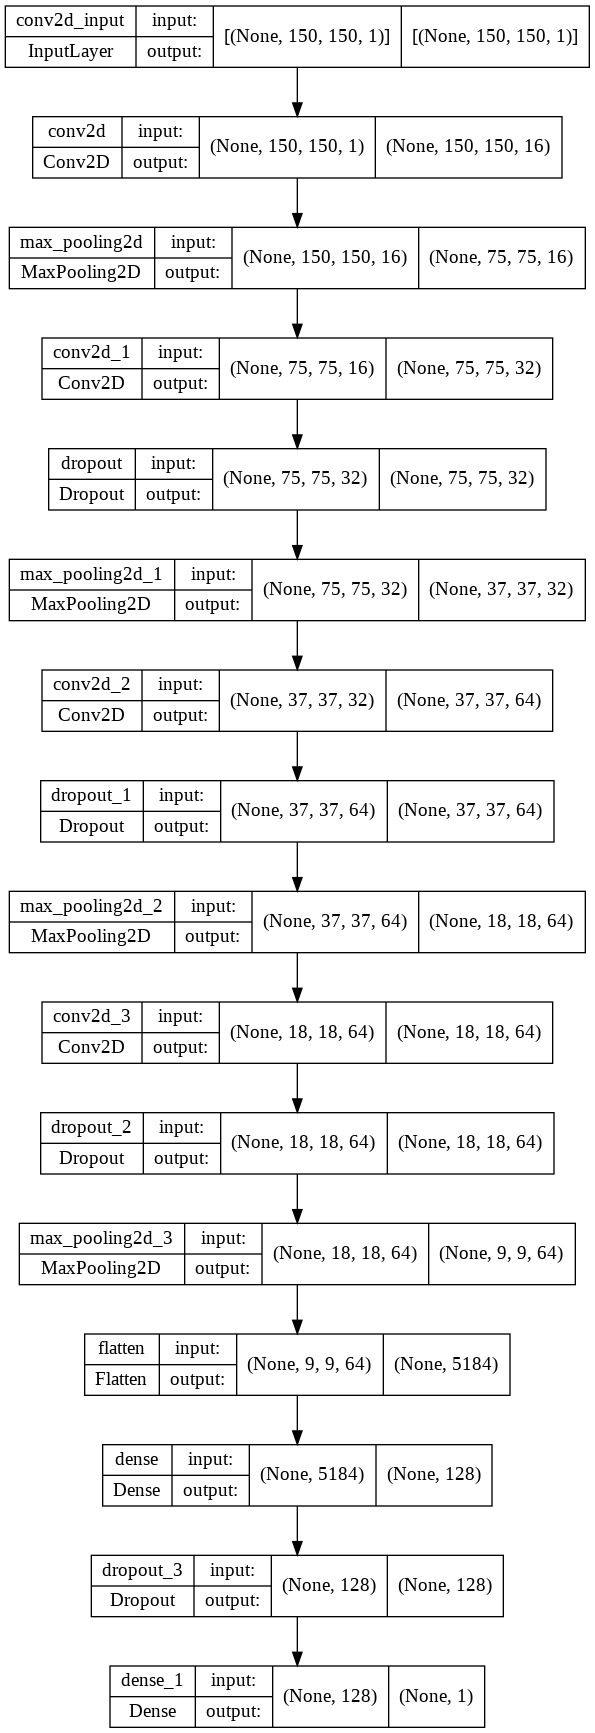

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Model Training

In [ ]:
#callback to reduce the learning rate over the training time to help the model from diverting
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 30, validation_data = datagen.flow(X_val, y_val), callbacks=[learning_rate_reduction],class_weight=class_weight)

Epoch 1/30
163/163 [==============================] - 15s 87ms/step - loss: 0.4967 - accuracy: 0.7337 - val_loss: 0.7315 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 14s 86ms/step - loss: 0.3231 - accuracy: 0.8639 - val_loss: 0.6409 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 14s 85ms/step - loss: 0.3045 - accuracy: 0.8635 - val_loss: 0.6923 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.8913
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 14s 85ms/step - loss: 0.2537 - accuracy: 0.8913 - val_loss: 0.6452 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - 14s 85ms/step - loss: 0.1979 - accuracy: 0.9174 - val_loss: 0.8415 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/30
163/163 [==============================

## Model Evaluation

In [ ]:
model_eval = model.evaluate(X_test, y_test)
print("Loss of the model is - " , model_eval[0])
print("Accuracy of the model is - " , model_eval[1]*100 , "%")

20/20 [==============================] - 1s 18ms/step - loss: 0.2456 - accuracy: 0.9247
Loss of the model is -  0.2455967664718628
Accuracy of the model is -  92.46794581413269 %


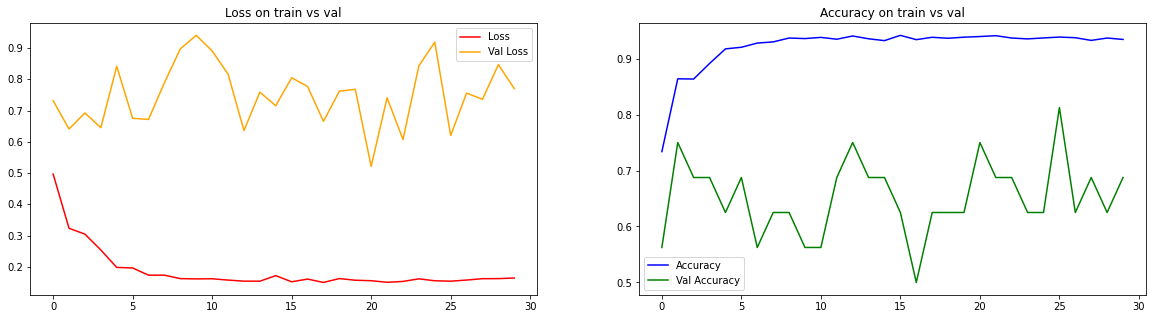

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs val')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs val')
plt.legend(loc='best')

plt.show()

In [26]:
predictions = model.predict(X_test)

In [27]:
#map predictions to classes
predictions = np.where(predictions > 0.5, 1,0)

In [28]:
print(classification_report(y_test, predictions, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.93      0.87      0.90       234
   Pneumonia       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



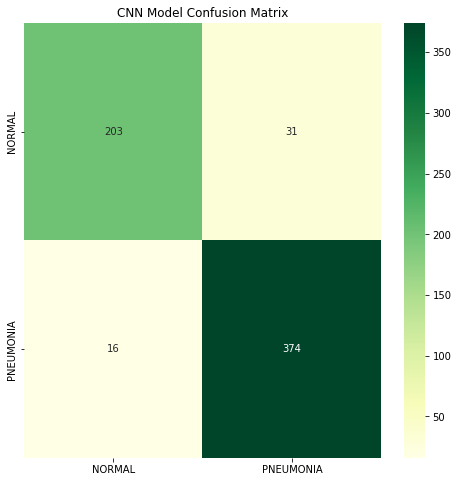

In [32]:
labels = ['NORMAL', 'PNEUMONIA']
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize = (8,8))
sns.heatmap(cm, cmap= "YlGn", annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('CNN Model Confusion Matrix')
plt.show()

In [33]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Recall of the model is {:.2f}".format(recall * 100))
print("Precision of the model is {:.2f}".format(precision * 100))

Recall of the model is 95.90
Precision of the model is 92.35


<a name="5"></a>
# Transfer Learning Using VGG16

## Pre Processing Inputs

Since the VGG16 model accpets the input in 3 channels format, we'll re-read the pictures but this time not in greyscale, but in the defualt 3 channels format.

In [35]:
#reading images
X_train, y_train = read_images_from_path('/content/chest_xray/train/', img_size, 0)
X_val, y_val = read_images_from_path('/content/chest_xray/val/', img_size, 0)
X_test, y_test = read_images_from_path('/content/chest_xray/test/', img_size, 0)

In [61]:
#normalize images to get them in range of 0:1
X_train = X_train /255
X_val = X_val /255
X_test = X_test /255 

In [36]:
print('X_train Shape: ' + str(X_train.shape))
print('X_test Shape: ' + str(X_test.shape))
print('X_val Shape: ' + str(X_val.shape))

X_train Shape: (5216, 150, 150, 3)
X_test Shape: (624, 150, 150, 3)
X_val Shape: (16, 150, 150, 3)


In [37]:
#re-fitting the data generator
datagen.fit(X_train)

## Loading and Setting Up VGG16

In [ ]:
#load vgg16 model not including the classifier
base_model = VGG16(weights="imagenet", include_top = False, input_shape = (150,150,3))
#freeze the model
base_model.trainable = False

In [40]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [148]:
# plot VGG16 filters and conv layers outputs
def visulaize_cnn(model, img_path, input_shape):
  filters, biases = model.layers[1].get_weights()
  layer = model.layers
  print('1st Conv Layer Filters')
  print(layer[1].name, filters.shape)

  fig1=plt.figure(figsize=(8, 12))
  columns = 8
  rows = 8
  n_filters = columns * rows
  for i in range(1, n_filters +1):
      f = filters[:, :, :, i-1]
      fig1 =plt.subplot(rows, columns, i)
      fig1.set_xticks([])  #Turn off axis
      fig1.set_yticks([])
      plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
  plt.show()        

  #Define a new truncated model to only include the conv layers of interest
  conv_layer_index = [1, 3, 6, 8, 11, 13, 15]
  outputs = [model.layers[i].output for i in conv_layer_index]
  model_short = Model(inputs=model.inputs, outputs=outputs)

  #Input shape to the model is 224 x 224. SO resize input image to this shape.
  img = load_img(img_path, target_size=input_shape)

  # convert the image to an array
  img = img_to_array(img)
  # expand dimensions to match the shape of model input
  img = np.expand_dims(img, axis=0)

  # Generate feature output by predicting on the input image
  feature_output = model_short.predict(img)


  columns = 8
  rows = 8
  conv_layer_no = 1
  for ftr in feature_output:
      fig=plt.figure(figsize=(12, 12))
      for i in range(1, columns*rows +1):
          fig =plt.subplot(rows, columns, i)
          fig.set_xticks([])
          fig.set_yticks([])
          plt.imshow(ftr[0, :, :, i-1], cmap='gray')
      print('-'*89)
      print(f'Conv Layer {conv_layer_no}')
      conv_layer_no += 1
      plt.show()

We can see from the following cell's outputs the conv layers outputs. As seen some of the filters detect the edges, while others might detect other features or finer details of the image. 

1st Conv Layer Filters
block1_conv1 (3, 3, 3, 64)


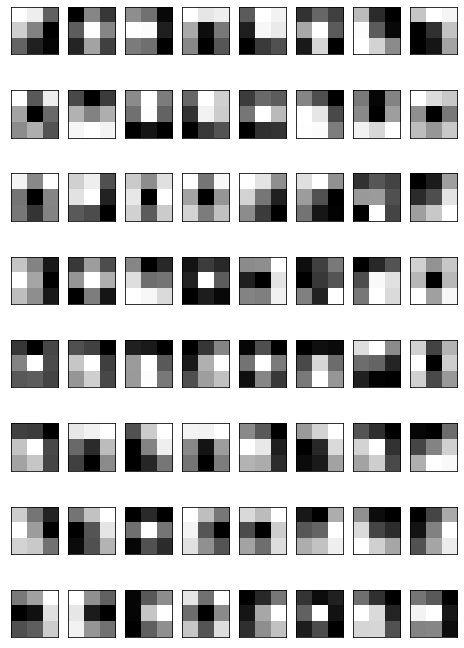

-----------------------------------------------------------------------------------------
Conv Layer 1


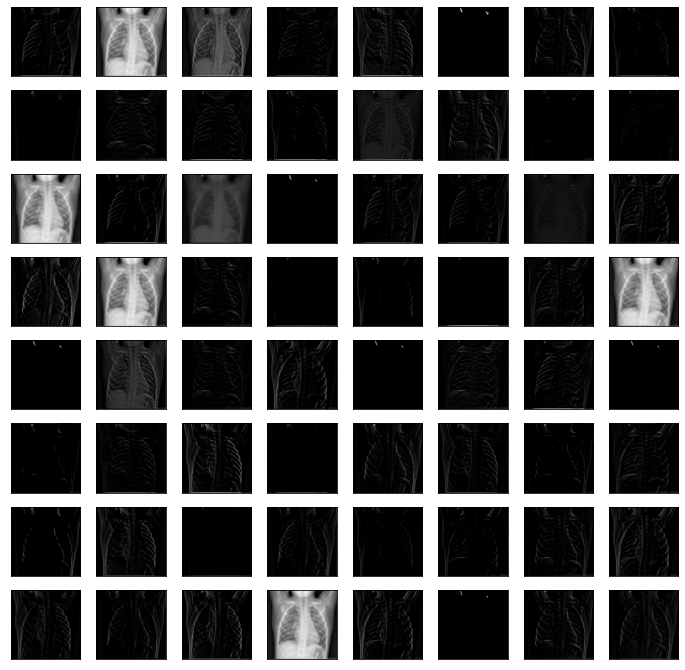

-----------------------------------------------------------------------------------------
Conv Layer 2


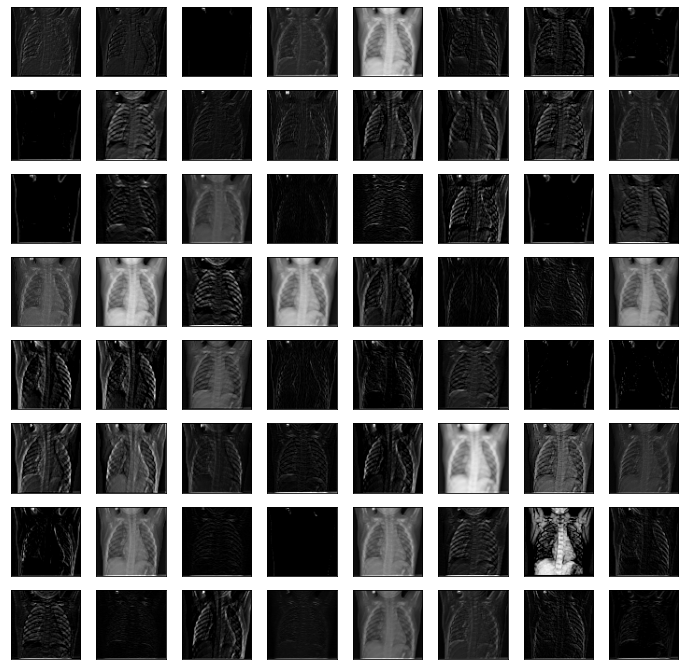

-----------------------------------------------------------------------------------------
Conv Layer 3


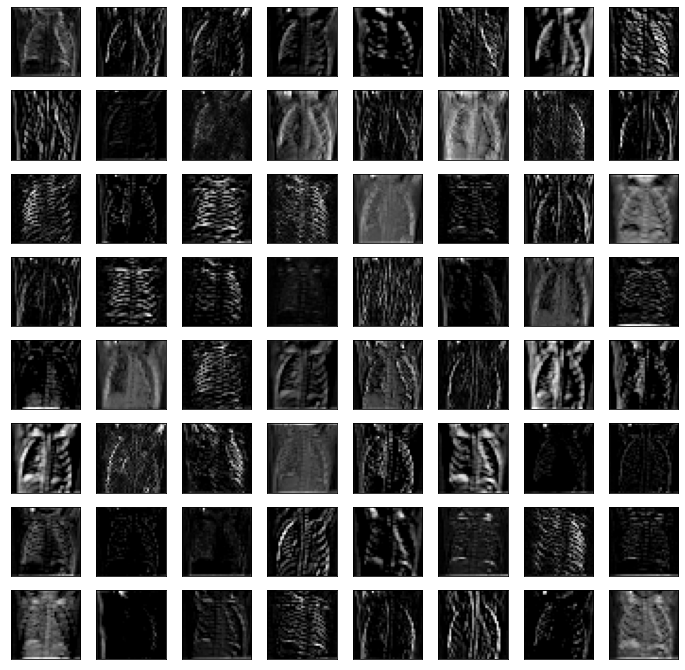

-----------------------------------------------------------------------------------------
Conv Layer 4


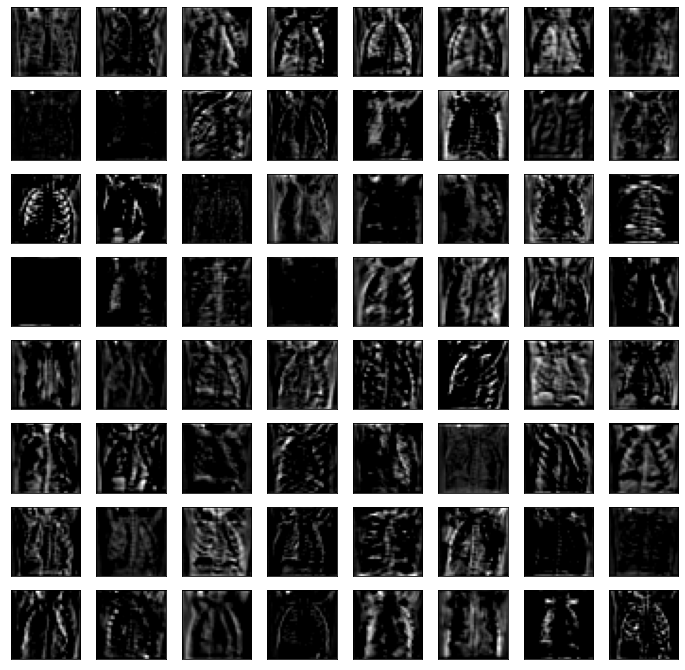

-----------------------------------------------------------------------------------------
Conv Layer 5


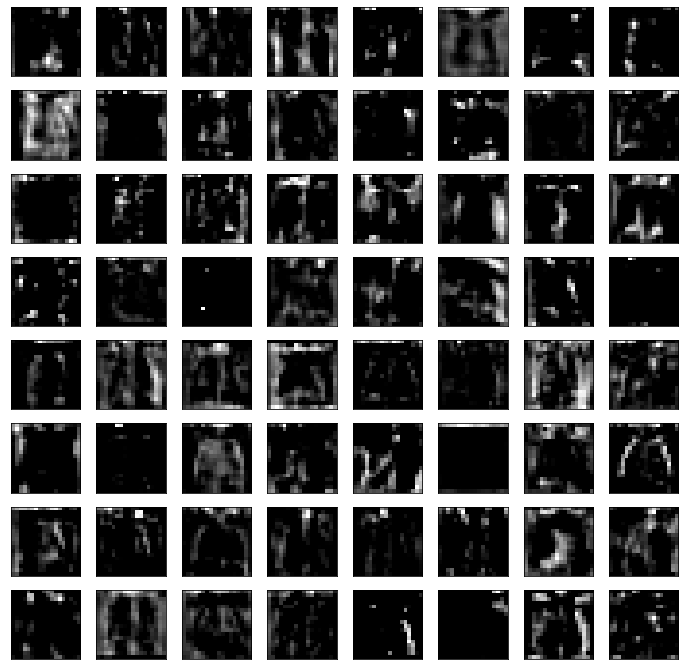

-----------------------------------------------------------------------------------------
Conv Layer 6


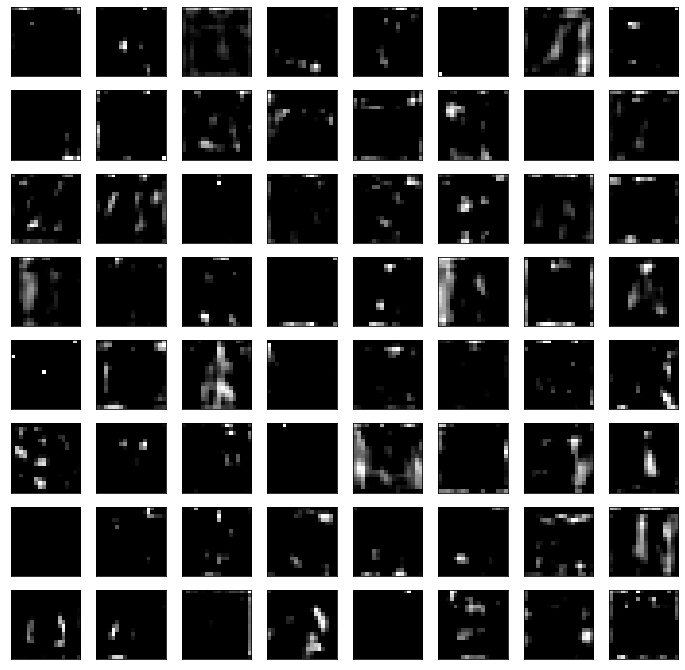

-----------------------------------------------------------------------------------------
Conv Layer 7


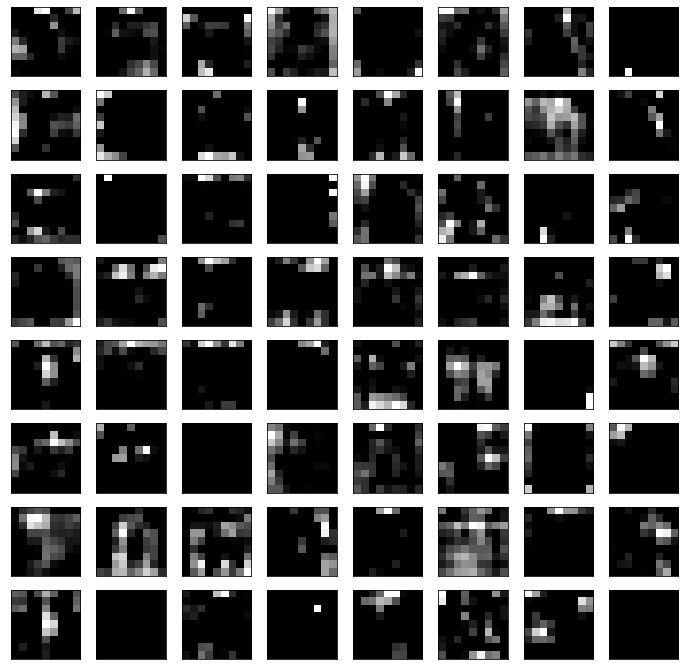

In [149]:
visulaize_cnn(base_model, '/content/x_ray.jpeg', (150,150))

In [41]:
#setting a classifier on top of the vgg16 model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


## VGG16-Based Model Training

In [ ]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 30, validation_data = datagen.flow(X_val, y_val))

Epoch 1/30
163/163 [==============================] - 50s 231ms/step - loss: 0.2636 - accuracy: 0.8942 - val_loss: 0.6611 - val_accuracy: 0.7500
Epoch 2/30
163/163 [==============================] - 36s 220ms/step - loss: 0.1769 - accuracy: 0.9342 - val_loss: 0.6084 - val_accuracy: 0.7500
Epoch 3/30
163/163 [==============================] - 36s 220ms/step - loss: 0.1611 - accuracy: 0.9354 - val_loss: 0.9687 - val_accuracy: 0.6875
Epoch 4/30
163/163 [==============================] - 36s 220ms/step - loss: 0.1534 - accuracy: 0.9385 - val_loss: 0.7199 - val_accuracy: 0.6875
Epoch 5/30
163/163 [==============================] - 36s 221ms/step - loss: 0.1482 - accuracy: 0.9459 - val_loss: 0.3057 - val_accuracy: 0.8750
Epoch 6/30
163/163 [==============================] - 36s 217ms/step - loss: 0.1471 - accuracy: 0.9442 - val_loss: 0.4655 - val_accuracy: 0.7500
Epoch 7/30
163/163 [==============================] - 36s 220ms/step - loss: 0.1370 - accuracy: 0.9461 - val_loss: 0.7896 - val_ac

## VGG16-Based Model Evaluation

In [ ]:
model_eval = model.evaluate(X_test, y_test)
print("Loss of the model is - " , model_eval[0])
print("Accuracy of the model is - " , model_eval[1]*100 , "%")

20/20 [==============================] - 3s 158ms/step - loss: 0.1965 - accuracy: 0.9407
Loss of the model is -  0.19649271667003632
Accuracy of the model is -  94.07051205635071 %


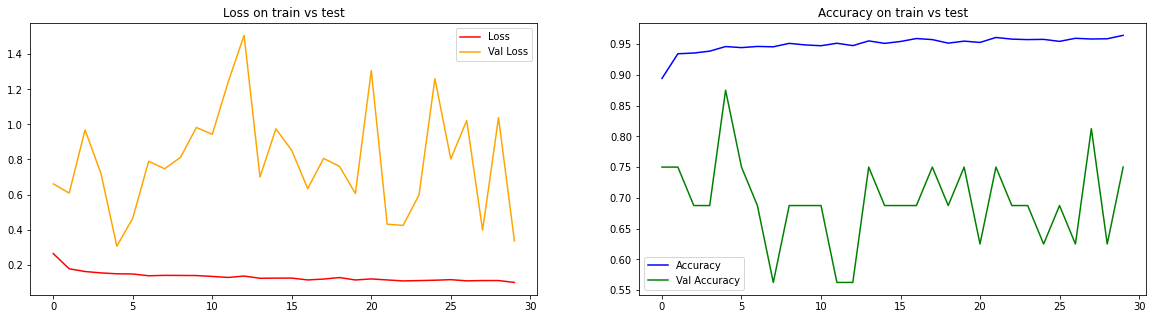

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

In [62]:
predictions = model.predict(X_test)

In [63]:
#map predictions to classes
predictions = np.where(predictions > 0.5, 1,0)

In [64]:
print(classification_report(y_test, predictions, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.94      0.90      0.92       234
   Pneumonia       0.94      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.94       624
weighted avg       0.94      0.94      0.94       624



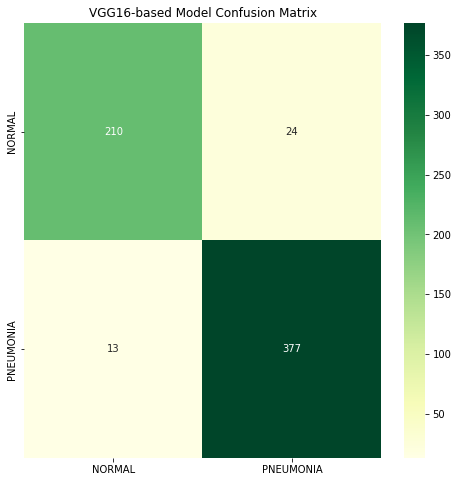

In [65]:
labels = ['NORMAL', 'PNEUMONIA']
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize = (8,8))
sns.heatmap(cm, cmap= "YlGn", annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('VGG16-based Model Confusion Matrix')
plt.show()

AUC: 0.9320512820512822


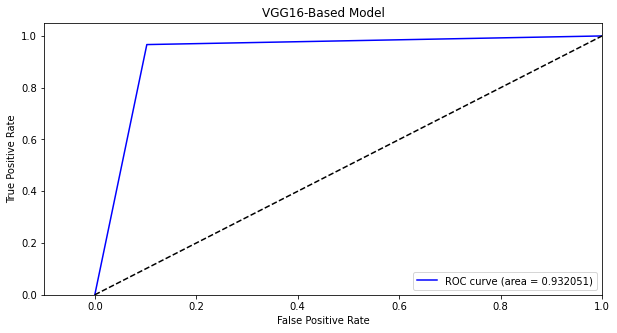

In [145]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = metrics.roc_auc_score(y_test, predictions)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'blue', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16-Based Model')
plt.legend(loc = "lower right")
plt.show()

In [66]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Recall of the model is {:.2f}".format(recall * 100))
print("Precision of the model is {:.2f}".format(precision * 100))

Recall of the model is 96.67
Precision of the model is 94.01


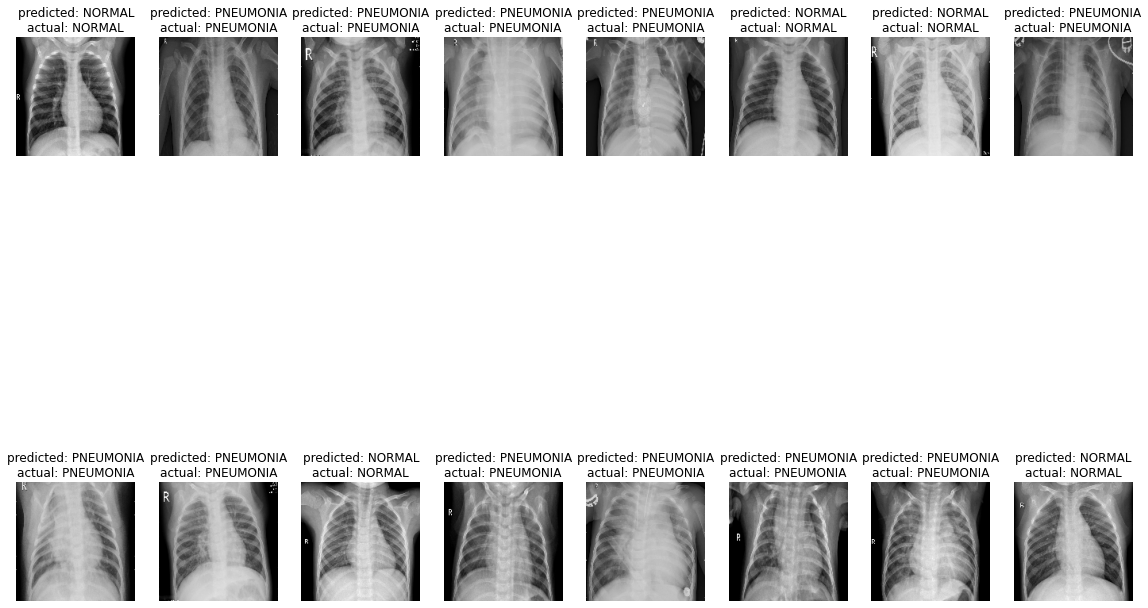

In [ ]:
#we pull 16 random images from the test data set and make predictions on them
plt.figure(figsize=(20,15))
for n , i in enumerate(np.random.randint(0,len(X_test),16)):
    plt.subplot(2,8,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    prediction = model.predict([X_test[i].reshape(1,150,150,3)])
    prediction = np.where(prediction[0] > 0.5, 1,0)
    plt.title('predicted: ' + str(getcode(prediction[0])) + '\n' + 'actual: '  + str(getcode(y_test[i])))

<a name="6"></a>
# Fine Tuning VGG16-Based Model

In this section we'll start fine tuning the vgg16-based model by unfreezing Conv layers from the VGG16 base model, allowing these layers to be updated in back propagation. 

##Unfreezing 1 Conv Block

In [ ]:
for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 30, validation_data = datagen.flow(X_val, y_val), class_weight = class_weight, callbacks = [learning_rate_reduction, checkpoint])

Epoch 1/30
163/163 [==============================] - 47s 233ms/step - loss: 0.2973 - accuracy: 0.8710 - precision: 0.9614 - recall: 0.8609 - val_loss: 0.5912 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 36s 223ms/step - loss: 0.1925 - accuracy: 0.9199 - precision: 0.9787 - recall: 0.9120 - val_loss: 0.8692 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9248 - precision: 0.9801 - recall: 0.9174
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 36s 221ms/step - loss: 0.1850 - accuracy: 0.9248 - precision: 0.9801 - recall: 0.9174 - val_loss: 0.6961 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 36s 222ms/step - loss: 0.157

In [ ]:
model_eval = model.evaluate(X_test, y_test)
print("Loss of the model is - " , model_eval[0])
print("Accuracy of the model is - " , model_eval[1]*100 , "%")

20/20 [==============================] - 3s 160ms/step - loss: 0.2092 - accuracy: 0.9295 - precision: 0.9505 - recall: 0.9359
Loss of the model is -  0.20921103656291962
Accuracy of the model is -  92.94871687889099 %


## Unfreezing 2 Conv Blocks

In [ ]:
for layer in base_model.layers[11:]:
    layer.trainable=True
for layer in base_model.layers[0:11]:
    layer.trainable=False

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 30, validation_data = datagen.flow(X_val, y_val), class_weight = class_weight, callbacks = [learning_rate_reduction, checkpoint])

Epoch 1/30
163/163 [==============================] - 40s 234ms/step - loss: 0.2600 - accuracy: 0.8861 - precision: 0.9649 - recall: 0.8787 - val_loss: 0.5369 - val_accuracy: 0.6875 - val_precision: 0.6364 - val_recall: 0.8750 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 36s 220ms/step - loss: 0.1872 - accuracy: 0.9241 - precision: 0.9775 - recall: 0.9190 - val_loss: 0.5333 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9250 - precision: 0.9770 - recall: 0.9208
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 37s 225ms/step - loss: 0.1907 - accuracy: 0.9250 - precision: 0.9770 - recall: 0.9208 - val_loss: 0.6308 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 36s 221ms/step - loss: 0.156

In [ ]:
model_eval = model.evaluate(X_test, y_test)
print("Loss of the model is - " , model_eval[0])
print("Accuracy of the model is - " , model_eval[1]*100 , "%")

20/20 [==============================] - 4s 158ms/step - loss: 0.2091 - accuracy: 0.9311 - precision: 0.9415 - recall: 0.9487
Loss of the model is -  0.20906227827072144
Accuracy of the model is -  93.10897588729858 %


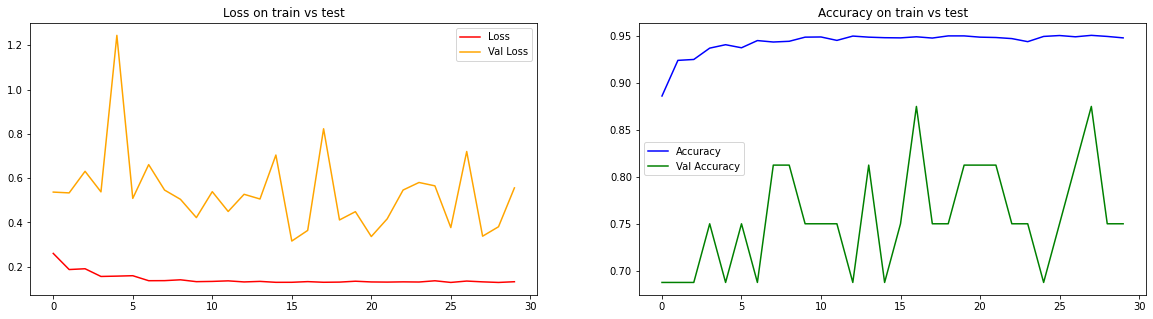

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Pneumonia Using CNN /93%pneumoniaVGG16.h5')

In [68]:
predictions = model.predict(X_test)

In [69]:
#map predictions to classes
predictions = np.where(predictions > 0.5, 1,0)

In [70]:
print(classification_report(y_test, predictions, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.91      0.90      0.91       234
   Pneumonia       0.94      0.95      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



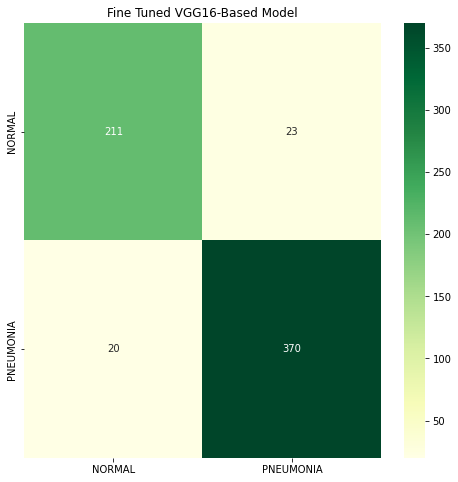

In [71]:
labels = ['NORMAL', 'PNEUMONIA']
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize = (8,8))
sns.heatmap(cm, cmap= "YlGn", annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('Fine Tuned VGG16-Based Model')
plt.show()

In [72]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Recall of the model is {:.2f}".format(recall * 100))
print("Precision of the model is {:.2f}".format(precision * 100))

Recall of the model is 94.87
Precision of the model is 94.15


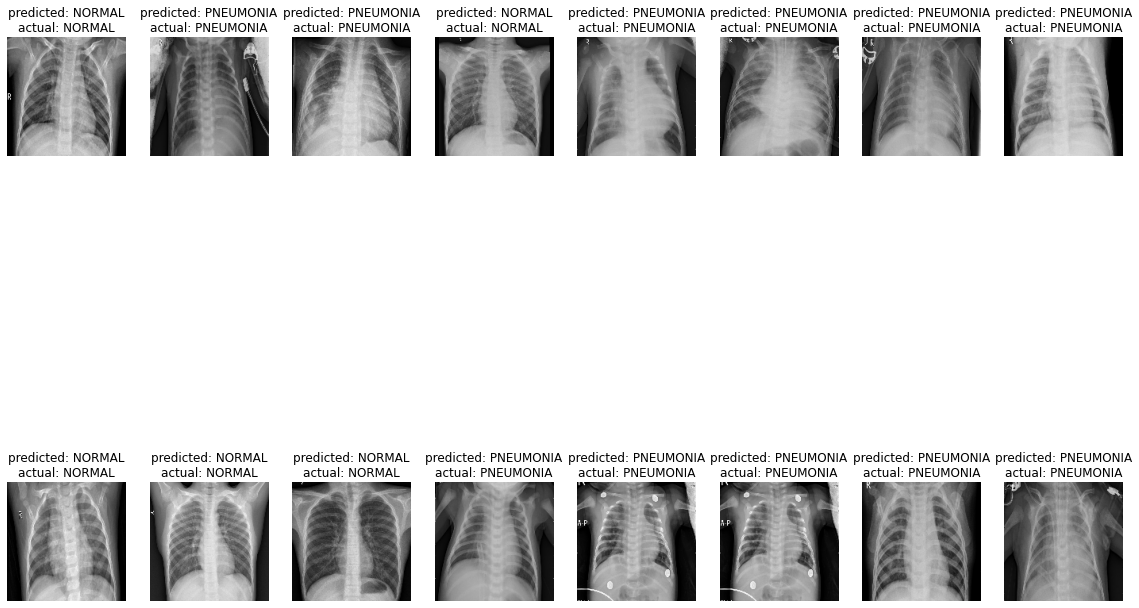

In [ ]:
#we pull 16 random images from the test data set and make predictions on them
plt.figure(figsize=(20,15))
for n , i in enumerate(np.random.randint(0,len(X_test),16)):
    plt.subplot(2,8,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    prediction = model.predict([X_test[i].reshape(1,150,150,3)])
    prediction = np.where(prediction[0] > 0.5, 1,0)
    plt.title('predicted: ' + str(getcode(prediction[0])) + '\n' + 'actual: '  + str(getcode(y_test[i])))

<a name="7"></a>
# Conclusion

As it turns out the original VGG16-based model is the best model of all the trials. The following metrics are of the model:
* Overall Accuray: 94%
* Overall Recall: 96.67%
* Overall Precision: 94.01%
* AUC Score: 93%